<a href="https://colab.research.google.com/github/danieljtrujillo/DataForecaster/blob/master/DataForecaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is a project demonstrating data prediction using 3 linear regression models.

*   Linear Regression using L2 regularization or Ridge Regression
*   Gradient Boosting Regressors
*   Neural Network based approaches using 1D Convolutions, LSTM layers with a Huber loss

The data we are predicting will be Adjusted Close prices for BAE Systems stock.

The historical stock prices for BAE Systems were downloaded from https://finance.yahoo.com/quote/BAESY for (Sept 3 2014 - Sept 3, 2019).

**GOOGLE COLAB USERS:** Runtime --> Change Runtime Type --> Hardware Accelerator -->GPU 
This will reduce time on Neural Network cells.

**Import necessary packages**
*    NumPy
*    Pandas
*    Matplotlib
*    Scikit-learn
*    Keras
*    Tensorflow




In [0]:
# Import necessary packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD

Using TensorFlow backend.


**Download RAW CSV from gihub repo**

In [0]:
# Download the data and store it
# In this example, BAE Systems stock, 5 years, stored as a csv on github. 
# IF YOU USE A CSV HOSTED ON GITHUB, YOU MUST USE THE LINK TO THE RAW FILE, NOT THE PAGE LINK

!wget -O BAESY.csv https://raw.githubusercontent.com/danieljtrujillo/DataForecaster/master/BAESY.csv?dl=1

--2019-09-06 01:52:45--  https://raw.githubusercontent.com/danieljtrujillo/DataForecaster/master/BAESY.csv?dl=1
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84890 (83K) [text/plain]
Saving to: ‘BAESY.csv’

BAESY.csv           100%[===================>]  82.90K  --.-KB/s    in 0.02s   

2019-09-06 01:52:46 (4.09 MB/s) - ‘BAESY.csv’ saved [84890/84890]



*   Read data using Pandas.
*   Set independent variable to *Date*
*   Display the first 5 entries



In [0]:
df = pd.read_csv('BAESY.csv')

In [0]:
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-04,29.900000,30.000000,29.600000,29.770000,24.504326,784700
2014-09-05,29.809999,29.850000,29.600000,29.799999,24.529020,142600
2014-09-08,29.190001,29.219999,28.930000,29.030001,23.895220,113900
2014-09-09,29.139999,29.230000,29.000000,29.120001,23.969299,226600
2014-09-10,29.410000,29.610001,29.299999,29.490000,24.273853,176300


*    Display *Adjusted Closing Price* for the last 5 years with the *Date* on the x-axis and *Price* on the y-axis




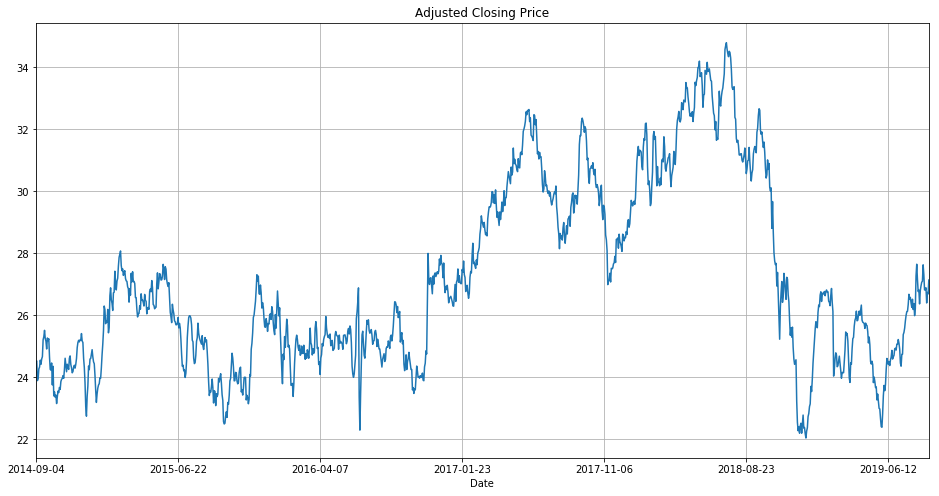

In [0]:
df['Adj Close'].plot(label='BAESY', figsize=(16,8), title='Adjusted Closing Price', grid=True)

By leveraging 90 prices from the past to predict the price on the 91st day, we can create a training example less affected by noise, and founded in historical data.

# *N*-90

*    ***N*** = number of days of downloaded stock data

Create a **2D matrix** of training samples wherein each row is ***Price*** of 90 consecutive days in the past and the ***Price*** to predict is the current day.

In [0]:
window_size = 90 # Allow us to look at 90 days into the past
# Prepare the data so that we have 90 day windows and predict what the next day should be

# Get indices of access for the data
num_samples = len(df) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)

In [0]:
data = df['Adj Close'].values[indices] # Create the 2D matrix of training samples

**CREATE 2D MATRIX WITH 91 COLUMNS**
*    columns 1-90 = training samples
*    column 91 = target variable (predicted price)

In [0]:
X = data[:,:-1] # Each row represents 90 days in the past
y = data[:,-1] # Each output value represents the 91st day

Perform train/test split such that the first 80% of the prices is the training set and the last 20% of the prices is the test dataset. We will train on the training set and test the performance on the test set to see how well we can forecast the price for BAE Systems stock.

In [0]:
# Train and test split
split_fraction = 0.8
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]

**Method #1 - Ridge Regression**

We will use the Ridge Regression method from Scikit-learn where we'll train and perform inference on the training and test data respectively. Let's also plot how it compares with the actual data for both training and test.

In [0]:
# Train
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Infer
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_ridge = ridge_model.predict(X_test)

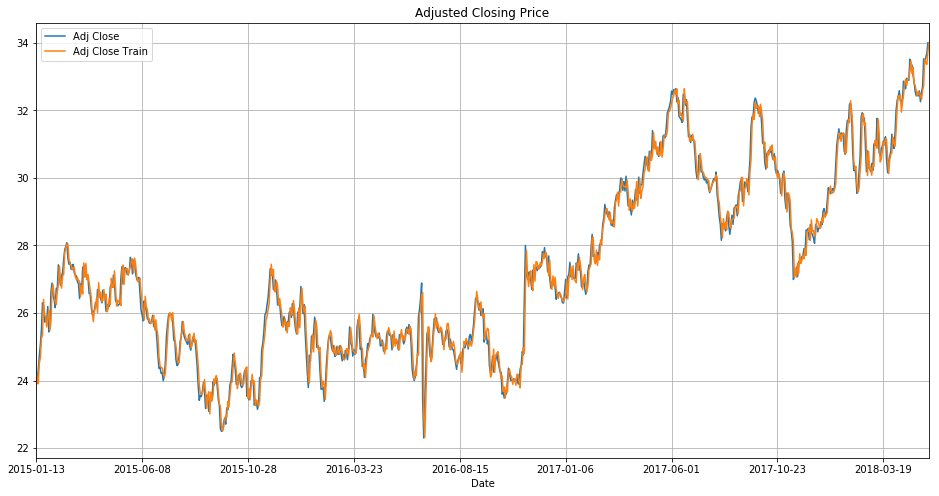

In [0]:
# Plot what it looks like for the training data
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[window_size:ind_split] # Past 90 days we don't know yet
df_ridge['Adj Close Train'] = y_pred_train_ridge[:-window_size]
df_ridge.plot(label='BAESY', figsize=(16,8), title='Adjusted Closing Price', grid=True)

The results are extremely similar, which could be indicative of overfitting, so we compare to our test data. 


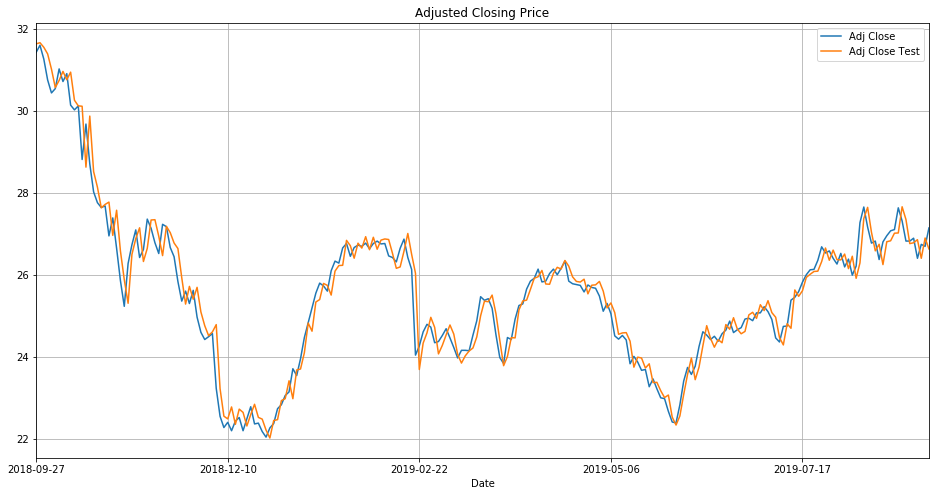

In [0]:
# Same for the test
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[ind_split+window_size:] # Past 90 days we don't know yet
df_ridge['Adj Close Test'] = y_pred_ridge
df_ridge.plot(label='BAESY', figsize=(16,8), title='Adjusted Closing Price', grid=True)

Once again, extremely similar.

**Method #2 - Gradient Boosting Trees**

Let's apply the same methodology from Method #1 to Gradient Boosting Trees in Scikit-learn.

In [0]:
# Model #2 - Gradient Boosting Trees
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Infer
y_pred_train_gb = gb_model.predict(X_train)
y_pred_gb = gb_model.predict(X_test)

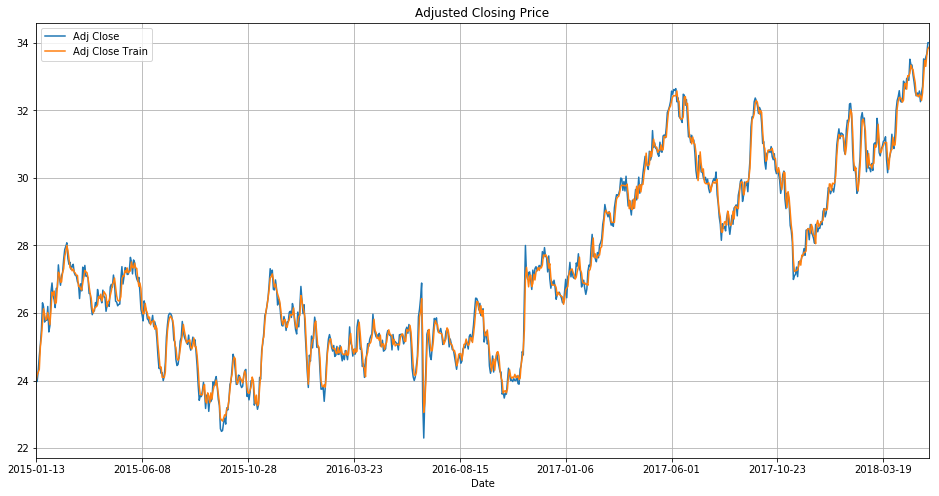

In [0]:
# Plot what it looks like for the training data
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[window_size:ind_split] # Past 90 days we don't know yet
df_gb['Adj Close Train'] = y_pred_train_gb[:-window_size]
df_gb.plot(label='BAESY', figsize=(16,8), title='Adjusted Closing Price', grid=True)

Once again, extremely similar. Review the test data.


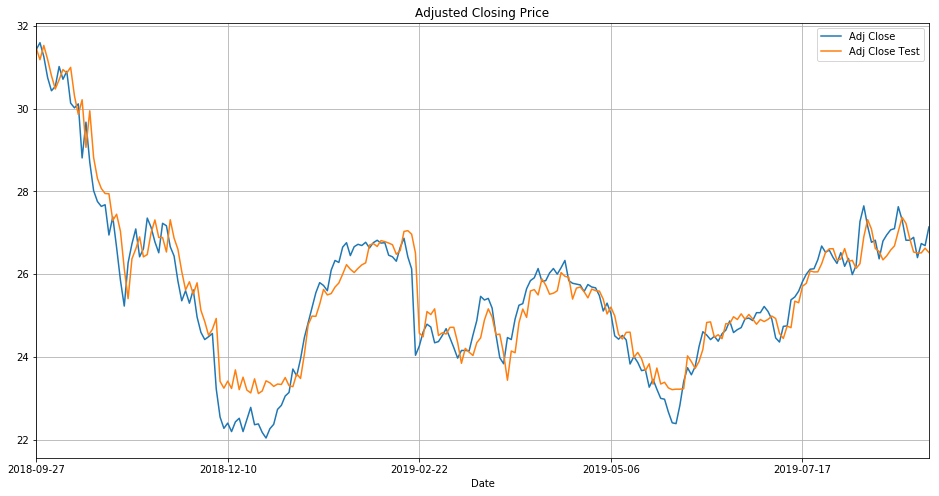

In [0]:
# Same for the test
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[ind_split+window_size:] # Past 90 days we don't know yet
df_gb['Adj Close Test'] = y_pred_gb
df_gb.plot(label='BAESY', figsize=(16,8), title='Adjusted Closing Price', grid=True)

The results here make sense. Since trees performing majority voting so there's no interpolation involved, we can see at points of high curvature, it doesn't do so well but the general trend is correct.


**Method #3 - Using neural networks with 1D convolutional and LSTM layers**

The last method we'll use is a neural network based one using Keras / Tensorflow. We use a stack of Conv1D and LSTM layers, followed by Dense layers lastly followed by a linear layer to predict the stock price.

In [0]:
# Model #3 - Using RNNs
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])

keras_model.summary()

W0906 01:52:50.480656 139749935732608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0906 01:52:50.540565 139749935732608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0906 01:52:50.551099 139749935732608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 90, 128)           768       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 90, 128)           82048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

This is a technique to find the optimal learning rate for the neural network. Specifically we gradually increase the learning rate at each epoch, recording the loss for each then choosing the learning rate that has the smallest loss overall.

Also, neural networks learn better when the data is normalized so we will normalize the data to the [−1,1] range by using Scikit-learn's MinMaxScaler. Therefore, we need to find apply this scaling on all of the price data, then decompose it into the training and test sets again.


In [0]:
# First figure out the right learning rate
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
# Scale the data due to LSTM units
scaler = MinMaxScaler(feature_range=(-1, 1))
data_transform = scaler.fit_transform(df['Adj Close'].values[:,None])
data_transform = data_transform[indices]
X2 = data_transform[:,:-1]
y2 = data_transform[:,-1]
X_train_reshape = X2[:ind_split]
y_train_reshape = y2[:ind_split]
X_test_reshape = X2[ind_split:]
y_test_reshape = y2[ind_split:]

W0906 01:52:51.266532 139749935732608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



We now try and find the optimal learning rate. If you're using Google Colab, this will take ~4 minutes.


In [0]:
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, callbacks=[lr_schedule], validation_data=(X_test_reshape, y_test_reshape))

W0906 01:52:51.478812 139749935732608 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0906 01:52:53.060199 139749935732608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0906 01:52:53.135048 139749935732608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 934 samples, validate on 234 samples
Epoch 1/250
934/934 [==============================] - 12s 13ms/step - loss: 0.1150 - mean_absolute_error: 0.4254 - val_loss: 0.1432 - val_mean_absolute_error: 0.4850
Epoch 2/250
934/934 [==============================] - 2s 2ms/step - loss: 0.1150 - mean_absolute_error: 0.4254 - val_loss: 0.1432 - val_mean_absolute_error: 0.4850
Epoch 3/250
934/934 [==============================] - 2s 2ms/step - loss: 0.1150 - mean_absolute_error: 0.4254 - val_loss: 0.1432 - val_mean_absolute_error: 0.4850
Epoch 4/250
934/934 [==============================] - 2s 2ms/step - loss: 0.1150 - mean_absolute_error: 0.4254 - val_loss: 0.1432 - val_mean_absolute_error: 0.4850
Epoch 5/250
934/934 [==============================] - 2s 2ms/step - loss: 0.1150 - mean_absolute_error: 0.4254 - val_loss: 0.1432 - val_mean_absolute_error: 0.4850
Epoch 6/250
934/934 [==============================] - 2s 2ms/step - loss: 0.1150 - mean_absolute_error: 0.4254 - val_loss: 0.1

Let's plot the loss for the testing data versus the learning rate. We can see that it explodes past a learning rate of 1, so let's focus our window to before this point.


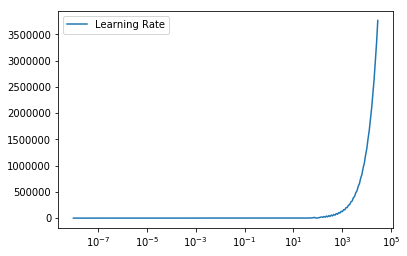

In [0]:
plt.semilogx(history.history['lr'], history.history['val_loss'])
plt.legend(['Learning Rate', 'Validation Loss'])

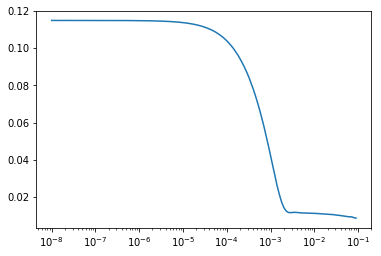

In [0]:
plt.semilogx(history.history['lr'][:140], history.history['loss'][:140])

It looks like the learning rate of 0.1 seems to work the best. Let's use that learning rate and train the network this time for real. Once we train the network, let's predict the prices for the training and test data.


In [0]:
# Observing the above graph, 0.1 seems to be the best learning rate
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])


optimizer = SGD(lr=0.1, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, validation_data=(X_test_reshape, y_test_reshape))

Train on 934 samples, validate on 234 samples
Epoch 1/250
934/934 [==============================] - 4s 4ms/step - loss: 0.0653 - mean_absolute_error: 0.2929 - val_loss: 0.0547 - val_mean_absolute_error: 0.2713
Epoch 2/250
934/934 [==============================] - 2s 2ms/step - loss: 0.0298 - mean_absolute_error: 0.1904 - val_loss: 0.0202 - val_mean_absolute_error: 0.1563
Epoch 3/250
934/934 [==============================] - 2s 2ms/step - loss: 0.0289 - mean_absolute_error: 0.1873 - val_loss: 0.0275 - val_mean_absolute_error: 0.1813
Epoch 4/250
934/934 [==============================] - 2s 2ms/step - loss: 0.0189 - mean_absolute_error: 0.1457 - val_loss: 0.0191 - val_mean_absolute_error: 0.1581
Epoch 5/250
934/934 [==============================] - 2s 2ms/step - loss: 0.0137 - mean_absolute_error: 0.1297 - val_loss: 0.0210 - val_mean_absolute_error: 0.1560
Epoch 6/250
934/934 [==============================] - 2s 2ms/step - loss: 0.0113 - mean_absolute_error: 0.1200 - val_loss: 0.023

Once we predict the values, we also must reverse the normalization so that we can plot the predictions in the same scale as the original values.

In [0]:
y_pred_train_keras = scaler.inverse_transform(keras_model.predict(X_train_reshape, batch_size=256))
y_pred_keras = scaler.inverse_transform(keras_model.predict(X_test_reshape, batch_size=256))

Let's now plot what the training and test predictions look like and compare witht he original values.


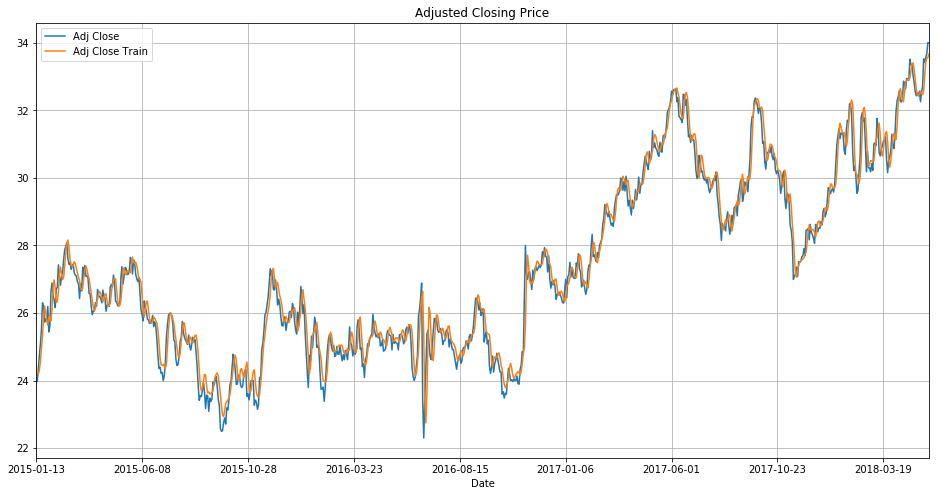

In [0]:
# Plot what it looks like for the training data
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[window_size:ind_split] # Past 90 days we don't know yet
df_keras['Adj Close Train'] = y_pred_train_keras[:-window_size]
df_keras.plot(label='BAESY', figsize=(16,8), title='Adjusted Closing Price', grid=True)

Again, quite accurate... and now for the test data.


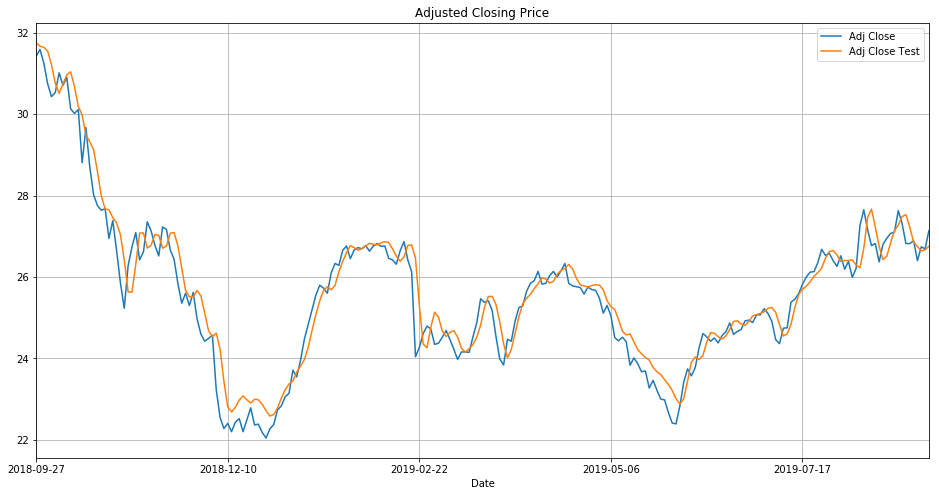

In [0]:
# Same for the test
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[ind_split+window_size:] # Past 90 days we don't know yet
df_keras['Adj Close Test'] = y_pred_keras
df_keras.plot(label='BAESY', figsize=(16,8), title='Adjusted Closing Price', grid=True)

I have more confidence in the neural network approach as it seems to indicate would the trend would be like when the data is noise free. We can also see a more smoother transition between points of high curvature.

Finally to see how everything performs, let's plot all of the methods together for both the training and testing data.


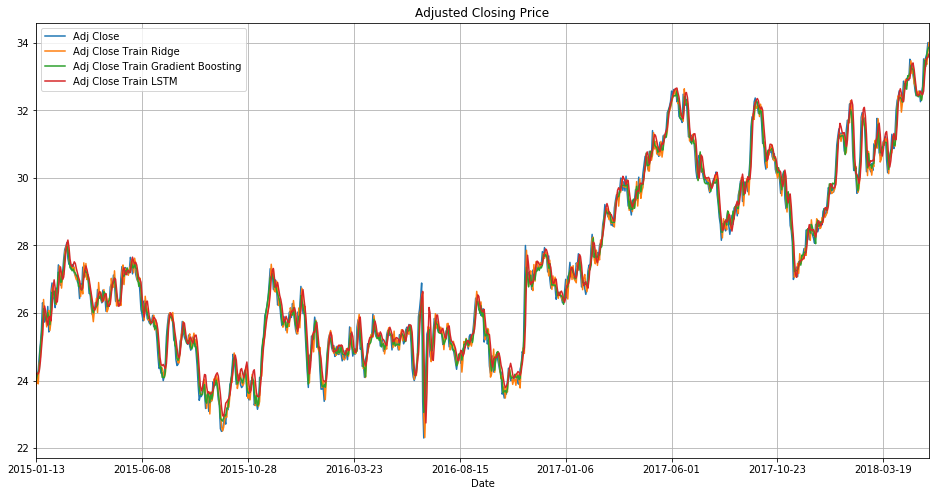

In [0]:
df_train = df.copy()
df_train.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_train = df_train.iloc[window_size:ind_split] # Past 90 days we don't know yet
# Add in all of our methods
df_train['Adj Close Train Ridge'] = y_pred_train_ridge[:-window_size]
df_train['Adj Close Train Gradient Boosting'] = y_pred_train_gb[:-window_size]
df_train['Adj Close Train LSTM'] = y_pred_train_keras[:-window_size]
# Plot the data now
df_train.plot(label='BAESY', figsize=(16,8), title='Adjusted Closing Price', grid=True)


Cool. They all more or less follow the same trend... and now for the testing data.

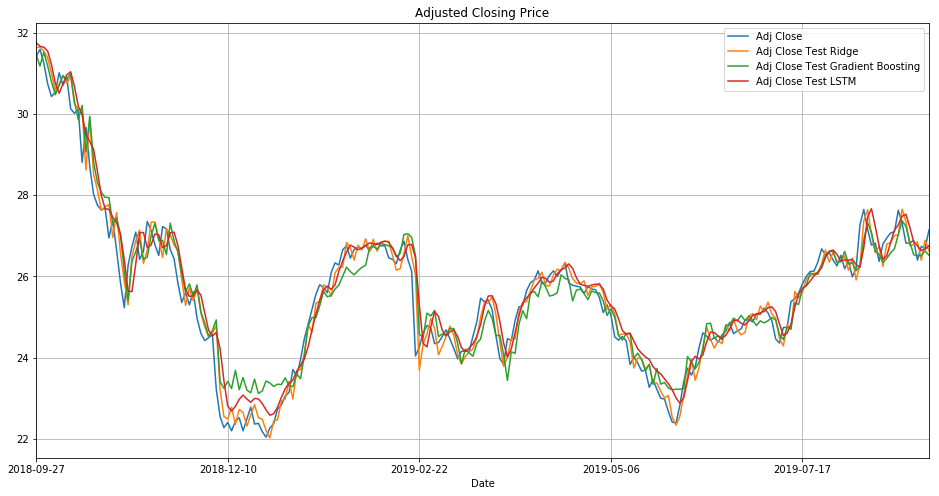

In [0]:
df_test = df.copy()
df_test.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_test = df_test.iloc[ind_split+window_size:] # Past 90 days we don't know yet
# Add in all of our methods
df_test['Adj Close Test Ridge'] = y_pred_ridge
df_test['Adj Close Test Gradient Boosting'] = y_pred_gb
df_test['Adj Close Test LSTM'] = y_pred_keras
# Plot the data now
df_test.plot(label='BAESY', figsize=(16,8), title='Adjusted Closing Price', grid=True)


So here's where it gets interesting. We can see that the neural network based method is what the values would be when there's no presence of noise. The ridge regression based method seems to follow the trend the best with the noise modelled in. The gradient boosting method also follows the same trend, but because the method does not use interpolation, points of very high curvature tend to be the most inaccurate.


**So what happens if we don't have testing data to try out?**

Good question. What you can do take the learned model that you have, then start with the last N values in your data (in my case 32), and start predicting what the next values will be. With the next values, keep using the previous N values for your desired forecasting.

We already have our learned models above, so let's go ahead and do that.

In [0]:
num_days = 30 # Let's try and forecast the next 30 days or two years

# Get the last window_size (90) days
data_seed = df['Adj Close'].values[-window_size:][None]
# Get the normalized data as well for the neural network
data_seed_norm = scaler.transform(data_seed)
input_values = {"ridge": data_seed, "gb": data_seed, "keras": data_seed_norm.copy()}
values = {"ridge": [], "gb": [], "keras": []}
for i in range(num_days): # For each day...
    # Predict the next price given the previous N prices
    values["ridge"].append(ridge_model.predict(input_values["ridge"])[0])
    values["gb"].append(gb_model.predict(input_values["gb"])[0])
    values["keras"].append(keras_model.predict(input_values["keras"][...,None])[0][0])

    # Dump the oldest price and put the newest price at the end
    for v in input_values:
        val = input_values[v]
        val = np.insert(val, -1, values[v][-1], axis=1)
        val = np.delete(val, 0, axis=1)
        input_values[v] = val.copy()

# Convert all to NumPy arrays
for v in input_values:
    values[v] = np.array(values[v])

# Unnormalize prices from NN approach
values["keras"] = scaler.inverse_transform(values["keras"][None])[0]
    

Plot the Forecasted Adjusted Closing Price (in this example I went with 30, though 10 seems optimal)

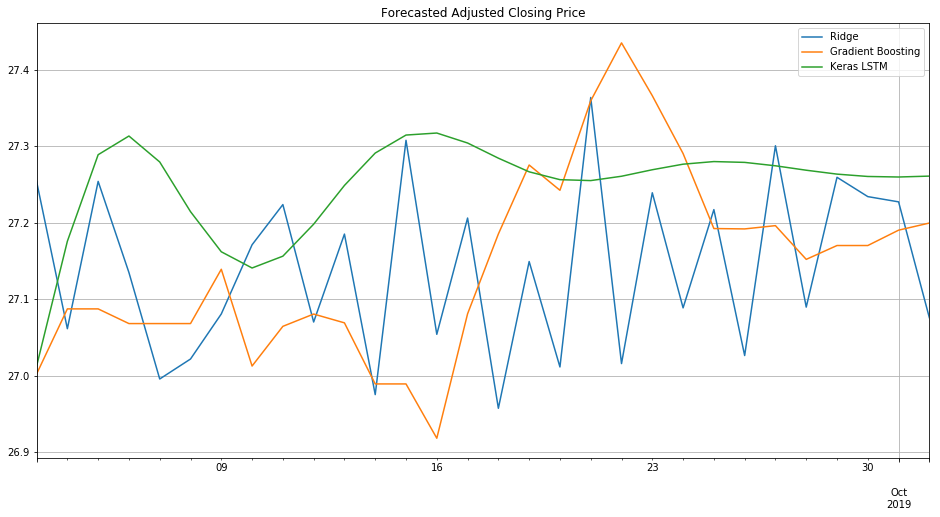

In [37]:
from datetime import timedelta, datetime
last_date = datetime.strptime(df.index[-1], '%Y-%m-%d')
df_forecast = pd.DataFrame()
df_forecast["Ridge"] = values["ridge"]
df_forecast["Gradient Boosting"] = values["gb"]
df_forecast["Keras LSTM"] = values["keras"]
df_forecast.index = pd.date_range(start=last_date, periods=num_days)
df_forecast.plot(label='BAESY', figsize=(16,8), title='Forecasted Adjusted Closing Price', grid=True)

If you project too far into the furture, the *Ridge* method starts following a repetitive high amplitude peak and valley pattern, where-as the *Gradient Boosting* doesn't present any noticeable pattern but eventually levels out, and the *LSTM* method steadily decreases in amplitude much like ripples